TODO: Add some `pooch` work here to pull down the example files and stash them in the users local cache.
TODO: Massage the data so that it's in the correct locations. My hunch here is that we can place all the files together in
the same directory. And we'll need to concatenate the parameters.fits files together.
The data files are sorted alphabetically, so we need to be careful about the way that we concatenate the parameters.fits
so that the ordering is maintained.

In [1]:
from hyrax import Hyrax

h = Hyrax()

[2025-08-29 16:52:05,654 hyrax:INFO] Runtime Config read from: /home/drew/code/hyrax/src/hyrax/hyrax_default_config.toml


In [2]:
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset
from torch import from_numpy
from hyrax.data_sets import HyraxDataset
from astropy.io import fits
from astropy.table import Table
from collections.abc import Generator


"""
Note - `index` this class refers to the row index in the parameters.fits file.
"""


class SLDataset(HyraxDataset, Dataset):
    def __init__(self, config: dict):
        super().__init__(config)
        self.data_directory = Path(config["general"]["data_dir"])
        self.metadata = self.read_metadata(self.data_directory)
        self.filepaths = self.read_filepaths(self.data_directory)

    def get_image(self, index: int):
        image_stack = np.zeros((5, 41, 41), dtype=np.float32)
        for b in range(5):
            file_index = index * 5 + b
            raw_data = fits.getdata(self.filepaths[file_index], memmap=False)
            image_stack[b] = raw_data[0][1]

        return from_numpy(image_stack)

    def get_label(self, index: int) -> np.ndarray[int]:
        file_index = index * 5
        ret_value = np.array([0.0, 1.0], dtype=np.float32)
        if "_L_" in str(self.filepaths[file_index]):
            ret_value = np.array([1.0, 0.0], dtype=np.float32)
        return from_numpy(ret_value)

    def get_object_id(self, index: int) -> str:
        id = "no_id"
        if "Lens ID" in self.metadata.columns and str(self.metadata[index]["Lens ID"]) != "--":
            id = str(self.metadata[index]["Lens ID"])
        elif "Object ID" in self.metadata.columns and str(self.metadata[index]["Object ID"]) != "--":
            id = str(self.metadata[index]["Object ID"])
        return id

    def get_filename(self, index: int) -> str:
        file_index = index * 5
        return str(self.filepaths[file_index].name)

    def read_filepaths(self, data_directory: Path):
        return sorted(list(data_directory.glob("*.fits")))

    def read_metadata(self, data_directory: Path):
        table = Table.read(data_directory / "parameters.fits")
        table["object_id"] = np.where(table["Lens ID"].mask, table["Object ID"], table["Lens ID"])
        return table

    def metadata_fields(self):
        return self.metadata.columns

    def ids(self) -> Generator[str]:
        for x in range(len(self)):
            yield str(self.get_object_id(x))

    def __len__(self):
        pattern = f"*_*.fits"
        files = list(self.data_directory.glob(pattern))
        return len(files) // 5

    def __getitem__(self, index: int):
        return {
            "image": self.get_image(index),
            "label": self.get_label(index),  # [1, 0] == lens, [0, 1] == non-lens
            "object_id": self.get_object_id(index),
        }

In [3]:
# h.config["general"]["data_dir"] = "/Users/drew/sl_data_challenge/sl_100/hsc_combined"
h.config["general"]["data_dir"] = "/home/drew/data/sl_100/hsc_combined"
h.config["data_set"]["name"] = "SLDataset"

ds = h.prepare()

[2025-08-29 16:52:11,298 hyrax.prepare:INFO] Finished Prepare


In [4]:
samp = ds[5]
print(f"ID: {samp['object_id']}")
print(f"Is lens? {samp['label']}")
print(f"Data shape: {samp['image'].shape}")


samp = ds[105]
print(f"ID: {samp['object_id']}")
print(f"Is lens? {samp['label']}")
print(f"Data shape: {samp['image'].shape}")

ID: 70360665344203068
Is lens? tensor([1., 0.])
Data shape: torch.Size([5, 41, 41])
ID: 41623412828827036
Is lens? tensor([0., 1.])
Data shape: torch.Size([5, 41, 41])


In [5]:
h.config["model"]["name"] = "HyraxCNN"
h.config["model"]["hyrax_cnn"]["output_classes"] = 2
h.config["train"]["epochs"] = 30
h.config["data_loader"]["batch_size"] = 10

In [6]:
h.train()

[2025-08-29 16:52:11,561 hyrax.models.model_registry:INFO] Using criterion: torch.nn.CrossEntropyLoss with default arguments.
[2025-08-29 16:52:11,562 hyrax.models.model_registry:INFO] Using optimizer: torch.optim.SGD with arguments: {'lr': 0.01, 'momentum': 0.9}.
2025-08-29 16:52:11,670 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<__main__.SLDataset': 
	{'sampler': <hyrax.pytorch_ignite.SubsetSequentialSampler object at 0x7e4924035190>, 'batch_size': 10, 'shuffle': False, 'pin_memory': True}
2025-08-29 16:52:11,671 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<__main__.SLDataset': 
	{'sampler': <hyrax.pytorch_ignite.SubsetSequentialSampler object at 0x7e492375f4d0>, 'batch_size': 10, 'shuffle': False, 'pin_memory': True}
/home/drew/miniconda3/envs/hyrax/lib/python3.12/site-packages/ignite/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` inste

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

[2025-08-29 16:52:53,462 hyrax.pytorch_ignite:INFO] Total training time: 41.17[s]
[2025-08-29 16:52:53,463 hyrax.pytorch_ignite:INFO] Latest checkpoint saved as: /home/drew/code/hyrax/docs/pre_executed/results/20250829-165211-train-mNtJ/checkpoint_epoch_30.pt
[2025-08-29 16:52:53,464 hyrax.pytorch_ignite:INFO] Best metric checkpoint saved as: /home/drew/code/hyrax/docs/pre_executed/results/20250829-165211-train-mNtJ/checkpoint_30_loss=-0.4241.pt
2025/08/29 16:52:53 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/08/29 16:52:53 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
[2025-08-29 16:52:53,477 hyrax.verbs.train:INFO] Finished Training
[2025-08-29 16:52:53,630 hyrax.model_exporters:INFO] Exported model to ONNX format: /home/drew/code/hyrax/docs/pre_executed/results/20250829-165211-train-mNtJ/example_model_opset_20.onnx


HyraxCNN(
  (conv1): Conv2d(5, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
  (criterion): CrossEntropyLoss()
)

In [7]:
h.infer()

[2025-08-29 16:52:53,727 hyrax.models.model_registry:INFO] Using criterion: torch.nn.CrossEntropyLoss with default arguments.
[2025-08-29 16:52:53,728 hyrax.models.model_registry:INFO] Using optimizer: torch.optim.SGD with arguments: {'lr': 0.01, 'momentum': 0.9}.
[2025-08-29 16:52:53,732 hyrax.verbs.infer:INFO] data set has length 200
2025-08-29 16:52:53,737 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<__main__.SLDataset': 
	{'sampler': None, 'batch_size': 10, 'shuffle': False, 'pin_memory': True}
[2025-08-29 16:52:53,746 hyrax.verbs.infer:INFO] Saving inference results at: /home/drew/code/hyrax/docs/pre_executed/results/20250829-165253-infer-Be8m
[2025-08-29 16:52:54,036 hyrax.pytorch_ignite:INFO] Evaluating model on device: cuda
[2025-08-29 16:52:54,038 hyrax.pytorch_ignite:INFO] Total epochs: 1


  5%|5         | 1/20 [00:00<?, ?it/s]

[2025-08-29 16:52:55,751 hyrax.pytorch_ignite:INFO] Total evaluation time: 1.71[s]
[2025-08-29 16:52:55,815 hyrax.verbs.infer:INFO] Inference Complete.


## Boilerplate code to generate the confusion matrix from the results of inference

In [8]:
from hyrax.data_sets import InferenceDataSet
from hyrax.config_utils import find_most_recent_results_dir
import torch

infer_dir = find_most_recent_results_dir(h.config, "infer")
infer_ds = InferenceDataSet(h.config, infer_dir)

lens_count = 0
nonlens_count = 0
confusion_matrix = np.zeros((2, 2))
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
for indx, id in enumerate(infer_ds.ids()):
    _, predicted = torch.max(infer_ds[indx], 0)
    if predicted == 0:
        lens_count += 1
    else:
        nonlens_count += 1

    orig_data = ds[indx]
    label = orig_data['label']
    
    # original object is lense
    if label[0] == 1.0:
        if predicted == 0: # predict lense true positive
            confusion_matrix[0][0] += 1
            true_pos += 1
        else: # predict non-lense - false negative
            confusion_matrix[0][1] += 1
            false_neg += 1

    # original object is non-lense
    elif label[0] == 0.0:
        if predicted == 0: # predict lense false positive
            confusion_matrix[1][0] += 1
            false_pos += 1
        else: # predict non-lense true negative
            confusion_matrix[1][1] += 1
            true_neg += 1

print(f"Total Lens: {lens_count}, Total Non-Lens: {nonlens_count}")
print(f"True Positives: {true_pos}, True Negatives: {true_neg}, False Positives: {false_pos}, False Negatives: {false_neg}")
print(f"Confusion matrix: {confusion_matrix}")

Total Lens: 88, Total Non-Lens: 112
True Positives: 24, True Negatives: 36, False Positives: 64, False Negatives: 76
Confusion matrix: [[24. 76.]
 [64. 36.]]


In [9]:
import matplotlib.pyplot as plt
import matplotlib
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(range(data.shape[1]), labels=col_labels,
                  rotation=-30, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


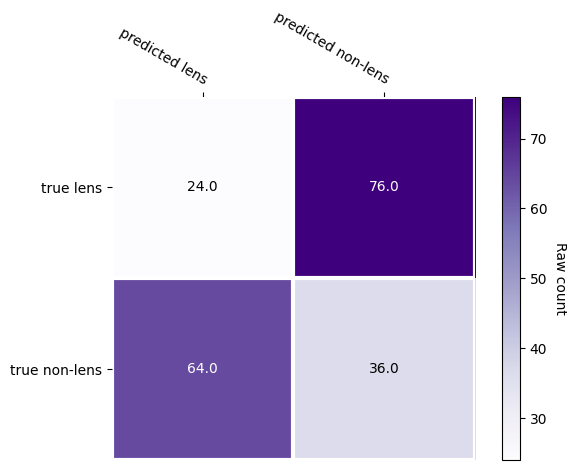

In [10]:

fig, ax = plt.subplots()
original_labels = ['true lens', 'true non-lens']
predicted_labels = ['predicted lens', 'predicted non-lens']

im, cbar = heatmap(confusion_matrix, original_labels, predicted_labels, ax=ax,
                   cmap="Purples", cbarlabel="Raw count")
texts = annotate_heatmap(im, valfmt="{x}")

fig.tight_layout()
plt.show()

In [11]:
h.config["model"]["name"] = "HyraxAutoencoderV2"
h.train()

[2025-08-29 16:52:58,269 hyrax.models.model_registry:INFO] Using criterion: torch.nn.CrossEntropyLoss with default arguments.
[2025-08-29 16:52:58,270 hyrax.models.model_registry:INFO] Using optimizer: torch.optim.SGD with arguments: {'lr': 0.01, 'momentum': 0.9}.
2025-08-29 16:52:58,275 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<__main__.SLDataset': 
	{'sampler': <hyrax.pytorch_ignite.SubsetSequentialSampler object at 0x7e4a4027e960>, 'batch_size': 10, 'shuffle': False, 'pin_memory': True}
2025-08-29 16:52:58,275 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<__main__.SLDataset': 
	{'sampler': <hyrax.pytorch_ignite.SubsetSequentialSampler object at 0x7e4a404b1070>, 'batch_size': 10, 'shuffle': False, 'pin_memory': True}
2025/08/29 16:52:58 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
[2025-08-29 16:52:58,311 hyrax.pytorch_ignite:INFO] Training model on device: cuda


  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

[2025-08-29 16:53:44,454 hyrax.pytorch_ignite:INFO] Total training time: 46.14[s]
[2025-08-29 16:53:44,454 hyrax.pytorch_ignite:INFO] Latest checkpoint saved as: /home/drew/code/hyrax/docs/pre_executed/results/20250829-165258-train-Iu9j/checkpoint_epoch_30.pt
[2025-08-29 16:53:44,455 hyrax.pytorch_ignite:INFO] Best metric checkpoint saved as: /home/drew/code/hyrax/docs/pre_executed/results/20250829-165258-train-Iu9j/checkpoint_30_loss=-2.3820.pt
2025/08/29 16:53:44 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/08/29 16:53:44 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
[2025-08-29 16:53:44,473 hyrax.verbs.train:INFO] Finished Training
[2025-08-29 16:53:44,620 hyrax.model_exporters:INFO] Exported model to ONNX format: /home/drew/code/hyrax/docs/pre_executed/results/20250829-165258-train-Iu9j/example_model_opset_20.onnx


HyraxAutoencoderV2(
  (encoder): Sequential(
    (0): Conv2d(5, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): GELU(approximate='none')
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU(approximate='none')
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): GELU(approximate='none')
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=2304, out_features=64, bias=True)
  )
  (dec_linear): Sequential(
    (0): Linear(in_features=64, out_features=2304, bias=True)
    (1): GELU(approximate='none')
  )
  (final_activation): Tanh()
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): GEL

In [12]:
h.infer()

[2025-08-29 16:53:44,721 hyrax.models.model_registry:INFO] Using criterion: torch.nn.CrossEntropyLoss with default arguments.
[2025-08-29 16:53:44,722 hyrax.models.model_registry:INFO] Using optimizer: torch.optim.SGD with arguments: {'lr': 0.01, 'momentum': 0.9}.
[2025-08-29 16:53:44,727 hyrax.verbs.infer:INFO] data set has length 200
2025-08-29 16:53:44,730 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<__main__.SLDataset': 
	{'sampler': None, 'batch_size': 10, 'shuffle': False, 'pin_memory': True}
[2025-08-29 16:53:44,749 hyrax.verbs.infer:INFO] Saving inference results at: /home/drew/code/hyrax/docs/pre_executed/results/20250829-165344-infer-k_4z
[2025-08-29 16:53:45,051 hyrax.pytorch_ignite:INFO] Evaluating model on device: cuda
[2025-08-29 16:53:45,053 hyrax.pytorch_ignite:INFO] Total epochs: 1


  5%|5         | 1/20 [00:00<?, ?it/s]

[2025-08-29 16:53:46,845 hyrax.pytorch_ignite:INFO] Total evaluation time: 1.79[s]
[2025-08-29 16:53:46,908 hyrax.verbs.infer:INFO] Inference Complete.


In [13]:
h.umap()

[2025-08-29 16:53:50,710 hyrax.data_sets.inference_dataset:INFO] Using most recent results dir /home/drew/code/hyrax/docs/pre_executed/results/20250829-165344-infer-k_4z for lookup. Use the [results] inference_dir config to set a directory or pass it to this verb.
[2025-08-29 16:53:50,777 hyrax.verbs.umap:INFO] Saving UMAP results to /home/drew/code/hyrax/docs/pre_executed/results/20250829-165350-umap-w1iY
[2025-08-29 16:53:51,112 hyrax.verbs.umap:INFO] Fitting the UMAP
[2025-08-29 16:53:56,791 hyrax.verbs.umap:INFO] Saving fitted UMAP Reducer


Creating lower dimensional representation using UMAP::   0%|          | 0/20 [00:00<?, ?it/s]

[2025-08-29 16:53:59,331 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP


[2025-08-29 16:54:03,650 hyrax.verbs.visualize:INFO] UMAP directory not specified at runtime. Reading from config values.
[2025-08-29 16:54:03,652 hyrax.data_sets.inference_dataset:INFO] Using most recent results dir /home/drew/code/hyrax/docs/pre_executed/results/20250829-165350-umap-w1iY for lookup. Use the [results] inference_dir config to set a directory or pass it to this verb.
[2025-08-29 16:54:03,718 hyrax.verbs.visualize:INFO] Rendering UMAP from the following directory: /home/drew/code/hyrax/docs/pre_executed/results/20250829-165350-umap-w1iY


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
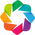

BokehModel(combine_events=True, render_bundle={'docs_json': {'727c7d66-a971-418e-a718-d30c2108ebed': {'version…

In [14]:
viz = h.visualize()